In [ ]:
#!pip install pmdarima sfrancia arch scipy

  Using cached Cython-3.0.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 30.3 MB/s eta 0:00:00
Using cached Cython-3.0.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)


In [189]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import AutoARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tsai.all import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
import optuna
import seaborn as sns
from scipy.stats import shapiro, kstest, jarque_bera
from statsmodels.stats.stattools import durbin_watson
from sfrancia import shapiroFrancia
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
import scipy.stats as stats
import scipy.stats as stats


class optuna_optimize:
    def __init__(self,arch,X,y,splits,epochs):
        self.arch = arch
        self.X = X
        self.y = y
        self.splits = splits
        self.epochs = epochs

    def optuna_objective(self,trial):
        hidden_size = trial.suggest_int('hidden_size', 16, 200)
        n_layers = trial.suggest_int('n_layers', 1, 5)
        rnn_dropout = trial.suggest_float('rnn_dropout', 0, 0.8)
        bidirectional = trial.suggest_categorical('bidirectional', [True, False])
        fc_dropout = trial.suggest_float('fc_dropout', 0, 0.8)
        learning_rate_model = trial.suggest_float('learning_rate_model', 1e-5, 1e-1,log=True)

        arch_config ={
            'hidden_size': hidden_size,
            'n_layers': n_layers,
            'rnn_dropout': rnn_dropout,
            'bidirectional': bidirectional,
            'fc_dropout': fc_dropout,
        }
        tfms = [None, TSForecasting()]
        learn = TSForecaster(self.X, self.y, splits=self.splits, path='models', tfms=tfms,
                            batch_tfms=TSStandardize(),
                            arch=self.arch, arch_config=arch_config,
                            cbs=[
                                ReduceLROnPlateau(patience=3), EarlyStoppingCallback(patience=5)
                            ],seed=1)
        
        with ContextManagers([learn.no_bar(),learn.no_logging()]):
            learn.fit_one_cycle(self.epochs, lr_max=learning_rate_model)
        
        return learn.recorder.values[-1][-1]
    

    def optuna_exponential_smoothing(self,trial):
        initialization_method = trial.suggest_categorical('initialization_method', ['estimated', 'heuristic'])
        alpha = trial.suggest_float('smoothing_level', 0.1, 1)
        beta = trial.suggest_float('smoothing_slope', 0.1, 1)
        gamma = trial.suggest_float('smoothing_seasonal', 0.1, 1)
        seasonal_periods = trial.suggest_int('seasonal_periods', 7, 31)

        fit, forecast = forecast_exponential_smoothing(series=self.X, new_data=self.y, initialization_method=initialization_method,
                                                        alpha=alpha, beta=beta, gamma=gamma, seasonal_periods=seasonal_periods)
        rmse= np.sqrt(mean_squared_error(self.y.flatten(), forecast.flatten()))

        return rmse



def forecast_arima(series, new_data, seasonal=False, m=1, arima_model=None,
                    start_p=4, start_q=0, d=None, max_p=10, max_q=10, max_d=3, max_order=None,
                    start_P=1, start_Q=1, D=None, max_P=8, max_Q=8, max_D=1):
    
    if not arima_model:
        arima_model = AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d,
                                max_q=max_q, max_order=max_order, start_P=start_P, D=D, start_Q=start_Q,
                                max_P=max_P, max_D=max_D, max_Q=max_Q, seasonal=seasonal, m=m,
                                trace=True, error_action='ignore', suppress_warnings=True,
                                stepwise=True, information_criterion='bic', scoring='mse',
                                with_intercept='auto')
        
    arima_model = arima_model.fit(y=series)
    
    lista_previsoes = []
    
    for j in range(new_data.shape[0]):
        previsao = arima_model.predict(n_periods=8)
        lista_previsoes.append(previsao)
        janela_8_dias = previsao
        arima_model = arima_model.update(janela_8_dias)
    
    forecast = np.array(lista_previsoes)
    return arima_model, forecast



def forecast_exponential_smoothing(series, new_data, trend='add', seasonal='add', seasonal_periods=7,
                                    initialization_method='heuristic', use_boxcox=False, bounds = None,
                                    alpha=None, beta=None, gamma=None):

    model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods,
                                  initialization_method=initialization_method, use_boxcox=use_boxcox)
    model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

    lista_previsoes = []
    new_series = series.copy()
    for j in range(new_data.shape[0]):
        previsao = model_fit.forecast(steps=8)
        lista_previsoes.append(previsao.values)
        new_series = pd.concat([new_series, previsao],axis=0)
        model = ExponentialSmoothing(new_series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods,
                                      initialization_method=initialization_method, use_boxcox=use_boxcox)
        model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

    forecast = np.array(lista_previsoes)
    return model_fit, forecast

def forecast_ann(X, y,splits,model = LSTMPlus, epochs=500,arch_config={},btfms=TSStandardize(),loss_func=nn.MSELoss(),cbs=[],lr = None):
    learn = TSForecaster(X, y,splits=splits, arch=model, metrics=[mae, rmse],arch_config=arch_config, batch_tfms=btfms, tfms=[None, [TSForecasting()]], loss_func=loss_func) # type: ignore
    with ContextManagers([learn.no_logging(), learn.no_bar()]):
        if not lr:
            lr = learn.lr_find() # Achar o melhor learning rate pro modelo, método da biblioteca fastai
            learn.fit_one_cycle(epochs, lr_max=lr.valley, cbs=cbs) # Treinar o modelo
        else:
            learn.fit_one_cycle(epochs, lr_max=lr, cbs=cbs)
        print(f'Métricas de Treinamento para {model}')
        display(pd.Series(learn.recorder.values[-1], index=learn.recorder.metric_names[1:5]))
        raw_preds, target, _ = learn.get_X_preds(X[splits[2]],y[splits[2]])
        return raw_preds,target



def decompose_series(series):
    decomposed = STL(series).fit()
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    resid = decomposed.resid
    #decomposed.plot()
    fig, axs = plt.subplots(4, 1, figsize=(14, 8))
    axs[0].plot(series)
    axs[0].set_title('Original Series')
    axs[1].plot(trend)
    axs[1].set_title('Trend')
    axs[2].plot(seasonal)
    axs[2].set_title('Seasonal')
    axs[3].scatter(series.index,resid)
    axs[3].set_title('Residual')
    plt.tight_layout()
    plt.savefig('decomposed.png')
    plt.show()
    return trend, seasonal, resid


def load_and_prepare_data(filepath):
    peru = pd.read_csv(filepath, index_col='index').rename(columns={'GPP': 'peru'})
    peru.index = pd.to_datetime(peru.index)
    peru = peru.resample('D').mean()
    return peru

def Default_LSTM(peru):

    indice_divisivel_por_oito = peru.shape[0] - (peru.shape[0] % 8)
    peru = peru.iloc[:indice_divisivel_por_oito]
    peru_splits = get_walk_forward_splits(peru.values.reshape(int(peru.shape[0] / 8),1,8),valid_size=0.15,test_size=0.15,anchored=True,n_splits=3)

    final_predictions = []
    real_values_list = []
    index_list = []

    for split in peru_splits:
        train = peru.iloc[split[0]]
        val = peru.iloc[split[1]]
        test = peru.iloc[split[2]]

        peru_dados = pd.concat([train, val, test], axis=0)

        percent_val = len(split[1]) /(len(split[0]) + len(split[1]) + len(split[2]))
        percent_test = len(split[2]) /(len(split[0]) + len(split[1]) + len(split[2]))

        peru_dados_x, peru_dados_y = SlidingWindow(window_len=8, horizon=8, stride=None)(peru_dados.values)
        splits_peru = TSSplitter(valid_size=percent_val,test_size=percent_test,show_plot=False)(peru_dados_y)

        optuna_opt = optuna_optimize(LSTMPlus,peru_dados_x,peru_dados_y,splits_peru,epochs=500)
        
        study = optuna.create_study(direction='minimize')
        study.optimize(optuna_opt.optuna_objective, n_trials=100)
        
        arch_config = study.best_params

        arch_config_without_lr = {key: value for key, value in arch_config.items() if key != 'learning_rate_model'}
        lr = study.best_params['learning_rate_model']

        peru_forecast, target_peru = forecast_ann(peru_dados_x, peru_dados_y, splits_peru, model=LSTMPlus, epochs=500,
                                                        arch_config=arch_config_without_lr, lr= lr,
                                                        btfms=TSStandardize(),loss_func=HuberLoss('mean'),cbs=[ReduceLROnPlateau(patience=3),EarlyStoppingCallback(patience=5)],
                                                        )
        final_predictions.extend(peru_forecast.numpy().flatten())
        real_values_list.extend(target_peru.numpy().flatten())

        indices = peru['peru'][peru['peru'].isin(peru_dados_y[splits_peru[2]].flatten())]
        index_list.extend(indices.index)

    final_predictions = np.array(final_predictions)
    real_values_list = np.array(real_values_list)
    index_list = np.array(index_list)

    rmse = mean_squared_error(real_values_list, final_predictions, squared=False)
    mae = mean_absolute_error(real_values_list, final_predictions)
    r2 = r2_score(real_values_list, final_predictions)
    mape = mean_absolute_percentage_error(real_values_list, final_predictions)
    corr = np.corrcoef(real_values_list, final_predictions)[0, 1]

    metricas_finais = {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape, 'corr': corr}

    return final_predictions, real_values_list, index_list, metricas_finais



def STL_ARIMA_ES_LSTM(peru):
    indice_divisivel_por_oito = peru.shape[0] - (peru.shape[0] % 8)
    peru = peru.iloc[:indice_divisivel_por_oito]

    peru_splits = get_walk_forward_splits(peru.values.reshape(int(peru.shape[0] / 8),1,8),valid_size=0.15,test_size=0.15,anchored=True,n_splits=3)

    final_predictions = []
    real_values_list = []

    for split in peru_splits:
        train = peru.iloc[split[0]]
        val = peru.iloc[split[1]]
        test = peru.iloc[split[2]]

        trend_train, seasonal_train, resid_train = decompose_series(train)
        trend_val, seasonal_val, resid_val = decompose_series(val)
        trend_test, seasonal_test, resid_test = decompose_series(test)

        resid = pd.concat([resid_train, resid_val, resid_test], axis=0)

        resid_x, resid_y = SlidingWindow(window_len=8, horizon=8, stride=None)(resid.values)

        percent_val = len(split[1]) /(len(split[0]) + len(split[1]) + len(split[2]))
        percent_test = len(split[2]) /(len(split[0]) + len(split[1]) + len(split[2]))

        splits_resid = TSSplitter(valid_size=percent_val,test_size=percent_test,show_plot=False)(resid_y)
        optuna_opt = optuna_optimize(LSTMPlus,resid_x,resid_y,splits_resid,epochs=500)
        study = optuna.create_study(direction='minimize')
        study.optimize(optuna_opt.optuna_objective, n_trials=100)

        arch_config = study.best_params

        arch_config_without_lr = {key: value for key, value in arch_config.items() if key != 'learning_rate_model'}
        lr = study.best_params['learning_rate_model']


        residual_forecast,target_residual = forecast_ann(resid_x, resid_y,splits_resid,model=LSTMPlus, epochs=500,
                                                        arch_config=arch_config_without_lr, lr= lr,
                                                        btfms=TSStandardize(),loss_func=HuberLoss('mean'),
                                                        cbs=[ReduceLROnPlateau(patience=3),EarlyStoppingCallback(patience=5)],
                                                        )
            
        arima_model, trend_forecast = forecast_arima(series=pd.concat([trend_train, trend_val]),new_data=trend_test.values.reshape(-1,1,8))
        
        optuna_es = optuna_optimize(ExponentialSmoothing,seasonal_train,seasonal_val.values.reshape(-1,1,8),None,epochs=None)
        study = optuna.create_study(direction='minimize')
        study.optimize(optuna_es.optuna_exponential_smoothing, n_trials=2)
        alpha = study.best_params['smoothing_level']
        beta = study.best_params['smoothing_slope']
        gamma = study.best_params['smoothing_seasonal']
        initialization_method = study.best_params['initialization_method']
        seasonal_periods = study.best_params['seasonal_periods']


        train_seasonal = pd.concat([seasonal_train,seasonal_val],axis=0)
        es_model, seasonal_forecast = forecast_exponential_smoothing(series=train_seasonal,new_data=seasonal_test.values.reshape(-1,1,8),trend=None,seasonal_periods=seasonal_periods,
                                                                     initialization_method=initialization_method,alpha=alpha,beta=beta,gamma=gamma)

        final_pred = residual_forecast.flatten() + seasonal_forecast.flatten() + trend_forecast.flatten()
        real_values = target_residual.numpy().flatten() + trend_test + seasonal_test
        real_values = real_values.values
        final_pred = final_pred.numpy()
        final_predictions.extend(final_pred)
        real_values_list.extend(real_values)

    final_predictions = np.array(final_predictions)
    real_values_list = np.array(real_values_list)


    rmse = mean_squared_error(real_values_list, final_predictions, squared=False)
    mae = mean_absolute_error(real_values_list, final_predictions)
    r2 = r2_score(real_values_list, final_predictions)
    mape = mean_absolute_percentage_error(real_values_list, final_predictions)
    corr = np.corrcoef(real_values_list, final_predictions)[0, 1]

    metricas_finais = {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape, 'corr': corr}
    return final_predictions, real_values_list, metricas_finais




def main():
    filepath = 'quistococha_MERRA.csv'
    peru = load_and_prepare_data(filepath)
    print('====================================================================================================')
    print('STL + ARIMA + ES + LSTM')
    hybrid_forecast, target_hybrid, metricas_hibrido = STL_ARIMA_ES_LSTM(peru=peru)
    print('====================================================================================================')
    print('Default LSTM')
    lstm_forecast, target_lstm, index_date, metricas_lstm = Default_LSTM(peru=peru)
    print('====================================================================================================')
    df_metrics = pd.DataFrame([metricas_hibrido, metricas_lstm], index=['STL-ARIMA-ES-LSTM', 'LSTM'])
    return hybrid_forecast, lstm_forecast, target_hybrid, target_lstm, index_date, df_metrics

In [190]:

def plot_boxplot(forecast1, forecast2, target1, target2, dt_index):
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2

    df_residuals = pd.DataFrame({
        'Residuals STL-ARIMA-ES-LSTM': preds_residuals1,
        'Residuals LSTM': preds_residuals2
    }, index=dt_index)
    df_residuals.to_csv('residuals.csv')


    df_residuals_melted = df_residuals.melt(var_name='Model', value_name='Residuals')

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=df_residuals_melted, x='Model', y='Residuals', ax=ax, width=0.6)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, label=None)
    ax.set_title('Box Plot of Residuals')
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Model')

    plt.tight_layout()
    plt.savefig('boxplot_comparison.png')
    plt.show()


def acf(forecast1, forecast2, target1, target2):
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    def plot_acf_custom(ax, residuals, title):
        sm.graphics.tsa.plot_acf(residuals, ax=ax)
        ax.set_title(title)

    plot_acf_custom(axs[0], preds_residuals1, 'Autocorrelation of Residuals (STL-ARIMA-ES-LSTM) (a)')
    plot_acf_custom(axs[1], preds_residuals2, 'Autocorrelation of Residuals (LSTM) (b)')

    plt.tight_layout()
    plt.savefig('acf.png')
    plt.show()

def plot_qq_hist_kde(forecast1, forecast2, target1, target2):
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2

    fig, axs = plt.subplots(2, 2, figsize=(13, 9))

    def plot_qq(ax, residuals, title):
        residuals = stats.zscore(residuals)
        sm.qqplot(residuals, line='s', ax=ax)
        ax.set_title(title)

    plot_qq(axs[0, 0], preds_residuals1, 'Q-Q Plot of Residuals (STL-ARIMA-ES-LSTM) (a)')
    plot_qq(axs[0, 1], preds_residuals2, 'Q-Q Plot of Residuals (LSTM) (b)')

    def plot_hist(ax, residuals, title):
        residuals_norm = stats.zscore(residuals)
        sns.histplot(x=residuals_norm, kde=True, ax=ax, stat='density', linewidth=0, bins=20)
        x_min, x_max = ax.get_xlim()
        x_axis = np.linspace(x_min, x_max, 100)
        normal_curve = stats.norm.pdf(x_axis, np.mean(residuals_norm), np.std(residuals_norm))
        ax.plot(x_axis, normal_curve, color='red', linestyle='--', linewidth=2, label='Normal Distribution')
        ax.set_title(title)
        ax.legend()

    plot_hist(axs[1, 0], preds_residuals1, 'Histogram with KDE of Normalized Residuals (STL-ARIMA-ES-LSTM) (c)')
    plot_hist(axs[1, 1], preds_residuals2, 'Histogram with KDE of Normalized Residuals (LSTM) (d)')

    plt.tight_layout()
    plt.savefig('qq_hist_kde.png')
    plt.show()
    


    print('Resumo dos resíduos do modelo STL-ARIMA-ES-LSTM:')
    hyp_tests(preds_residuals1)
    print('====================================================================================================')
    print('Resumo dos resíduos do modelo LSTM:')
    hyp_tests(preds_residuals2)


def residual_general_summary(forecast1, forecast2, target1, target2, dt_index):
    sns.set_style('darkgrid')
    plot_qq_hist_kde(forecast1, forecast2, target1, target2)
    acf(forecast1, forecast2, target1, target2)
    plot_boxplot(forecast1, forecast2, target1, target2, dt_index)



def residual_summary(forecast, target, dt_index):
    sns.set_style('darkgrid')
    preds_residuals = forecast - target
    residuos = pd.Series(data=preds_residuals, index=dt_index)
    display(residuos)
    print(residuos.describe())

    # Configuração do layout dos subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))

    # Residuals vs Fitted Values plot
    axes[0, 0].scatter(forecast, preds_residuals)
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].set_title('Residuals vs Fitted Values')

    # Q-Q plot of residuals to check normality
    sm.qqplot(preds_residuals, line='s', ax=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot of Residuals')

    # Histogram of residuals
    sns.histplot(x=preds_residuals, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Histogram with KDE of Residuals')

    # Autocorrelation plot of residuals
    plot_acf(preds_residuals, ax=axes[1, 1])
    axes[1, 1].set_title('Autocorrelation of Residuals')

    # Residuals vs Time
    axes[2, 0].plot(preds_residuals)
    axes[2, 0].axhline(0, color='red', linestyle='--')
    axes[2, 0].set_title('Residuals over Time')

    # Remove the last empty subplot
    sns.boxplot(x=preds_residuals, ax=axes[2, 1])
    axes[2, 1].set_title('Boxplot of Residuals')

    plt.tight_layout()
    plt.show()

def hyp_tests(residuos):
    shap = shapiro(residuos)
    shapiro_pvalue = shap[1]
    if shapiro_pvalue > 0.05:
        shapiro_interpretation = "Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05)."
    else:
        shapiro_interpretation = "Rejeitamos a hipótese nula de que os resíduos seguem uma distribuição normal (p <= 0.05)."

    kstest_pvalue = kstest(residuos, 'norm')[1]
    if kstest_pvalue > 0.05:
        kstest_interpretation = "Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05)."
    else:
        kstest_interpretation = "Rejeitamos a hipótese nula de que os resíduos seguem uma distribuição normal (p <= 0.05)."

    durbin_watson_stat = durbin_watson(residuos)
    if durbin_watson_stat < 1.5 or durbin_watson_stat > 2.5:
        durbin_watson_interpretation = "Possível autocorrelação nos resíduos (Durbin-Watson fora do intervalo 1.5-2.5)."
    else:
        durbin_watson_interpretation = "Não há evidência de autocorrelação nos resíduos (Durbin-Watson dentro do intervalo 1.5-2.5)."

    shapiro_francia_pvalue = shapiroFrancia(residuos)['p-value']
    if shapiro_francia_pvalue > 0.05:
        shapiro_francia_interpretation = "Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05)."
    else:
        shapiro_francia_interpretation = "Rejeitamos a hipótese nula de que os resíduos seguem uma distribuição normal (p <= 0.05)."

    # Teste Ljung-Box para autocorrelação residual
    lb_pvalue = acorr_ljungbox(residuos)
    if np.any(lb_pvalue.values < 0.05):
        lb_interpretation = "Evidência significativa de autocorrelação nos resíduos."
    else:
        lb_interpretation = "Não há evidência significativa de autocorrelação nos resíduos."

    # Teste Jarque-Bera para normalidade dos resíduos
    jb_pvalue = jarque_bera(residuos)
    if jb_pvalue.pvalue < 0.05:
        jb_interpretation = "Os resíduos não seguem uma distribuição normal."
    else:
        jb_interpretation = "Os resíduos seguem uma distribuição normal."

    # Teste ARCH para heterocedasticidade condicional
    model_arch = arch_model(residuos)
    result = model_arch.fit(disp='off')
    arch_lm_test = result.arch_lm_test()
    arch_lm_pvalue = arch_lm_test.pval
    if arch_lm_pvalue < 0.05:
        arch_lm_interpretation = "Há evidência de heterocedasticidade condicional nos resíduos."
    else:
        arch_lm_interpretation = "Não há evidência de heterocedasticidade condicional nos resíduos."

    print("\nResumo das análises estatísticas:")
    print("Shapiro-Wilk Test p-value:", shapiro_pvalue, "-", shapiro_interpretation)
    print("Kolmogorov-Smirnov Test p-value:", kstest_pvalue, "-", kstest_interpretation)
    print("Durbin-Watson Statistic:", durbin_watson_stat, "-", durbin_watson_interpretation)
    print("Shapiro-Francia Test p-value:", shapiro_francia_pvalue, "-", shapiro_francia_interpretation)
    print("Ljung-Box Test p-value:", lb_pvalue, "-", lb_interpretation)
    print("Jarque-Bera Test p-value:", jb_pvalue.pvalue, "-", jb_interpretation)
    print("ARCH LM Test p-value:", arch_lm_pvalue, "-", arch_lm_interpretation)


STL + ARIMA + ES + LSTM


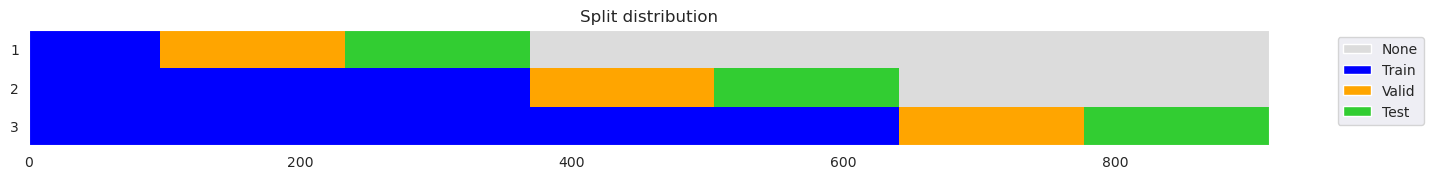

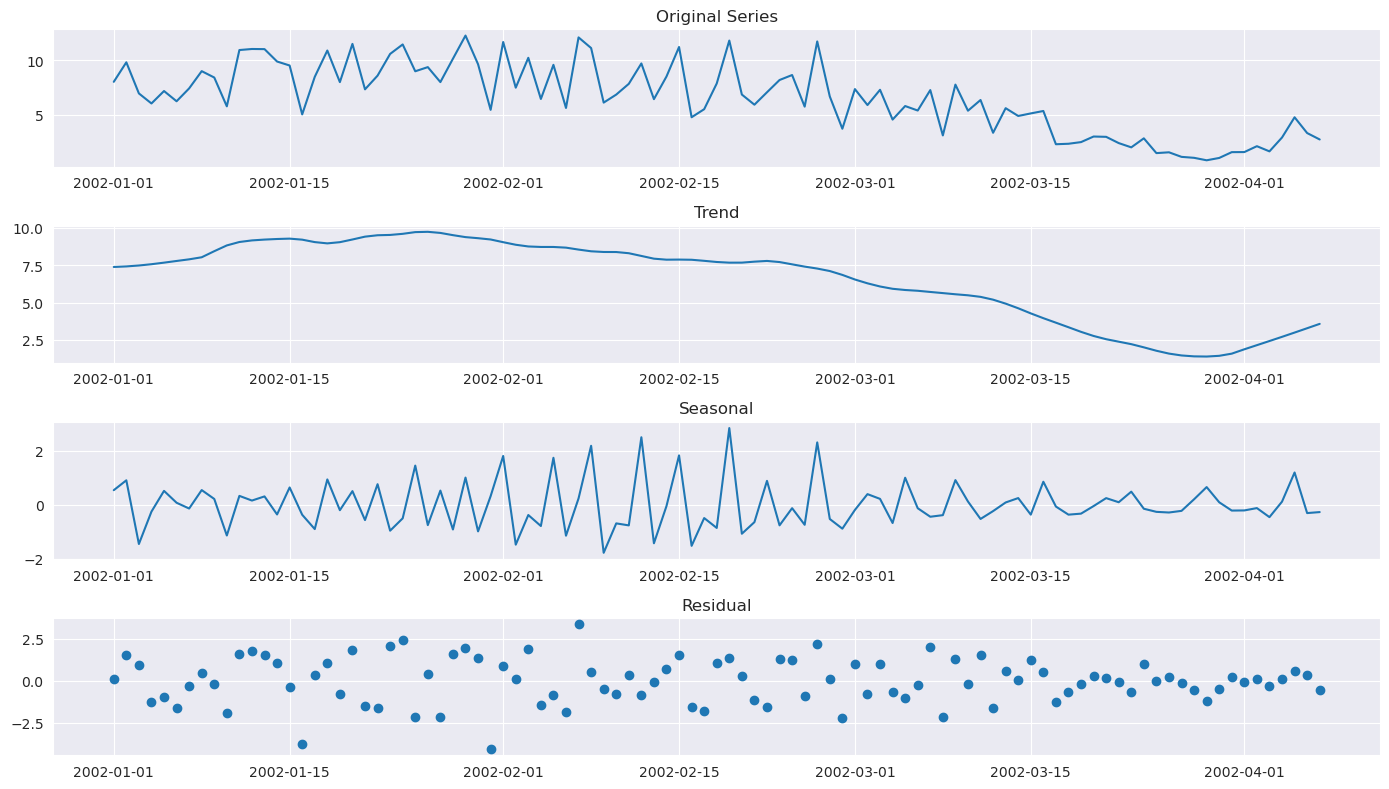

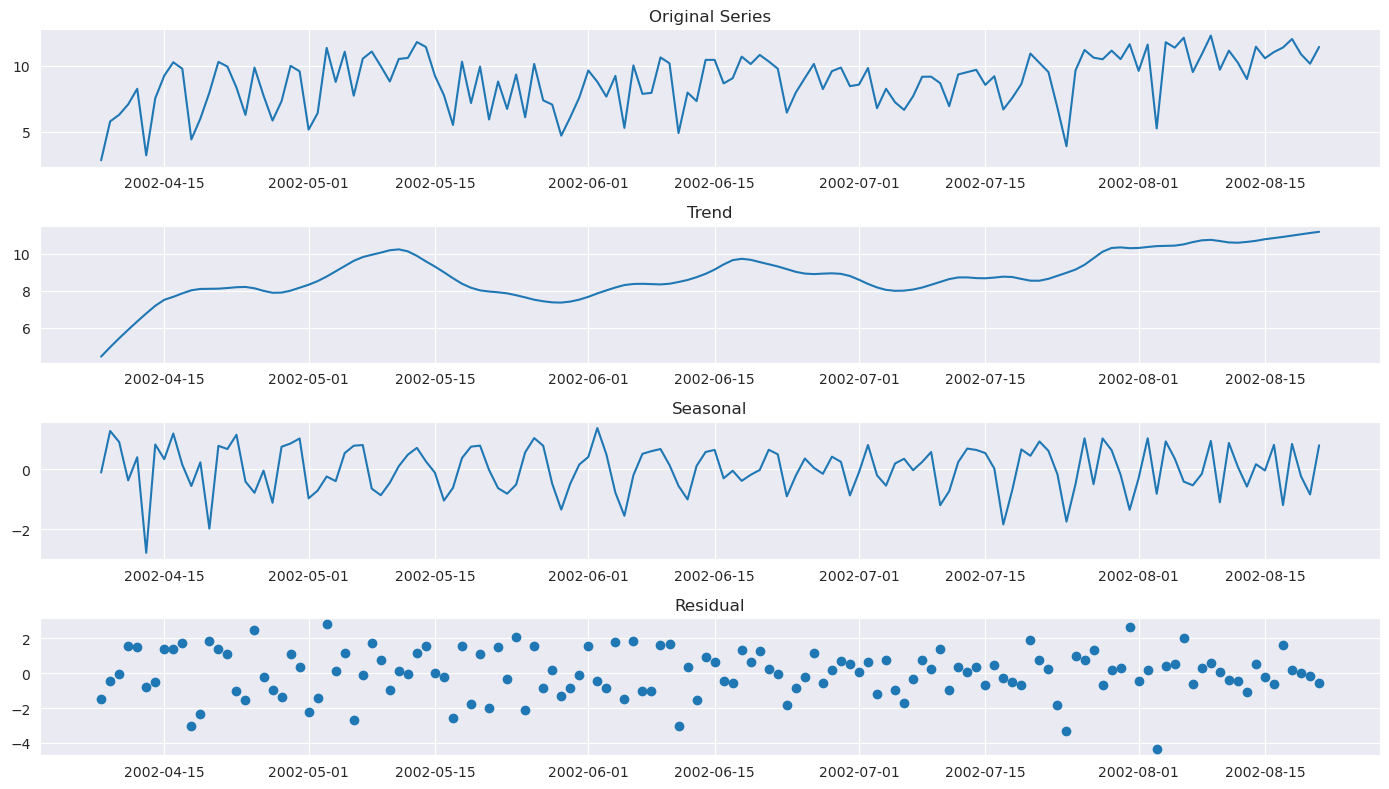

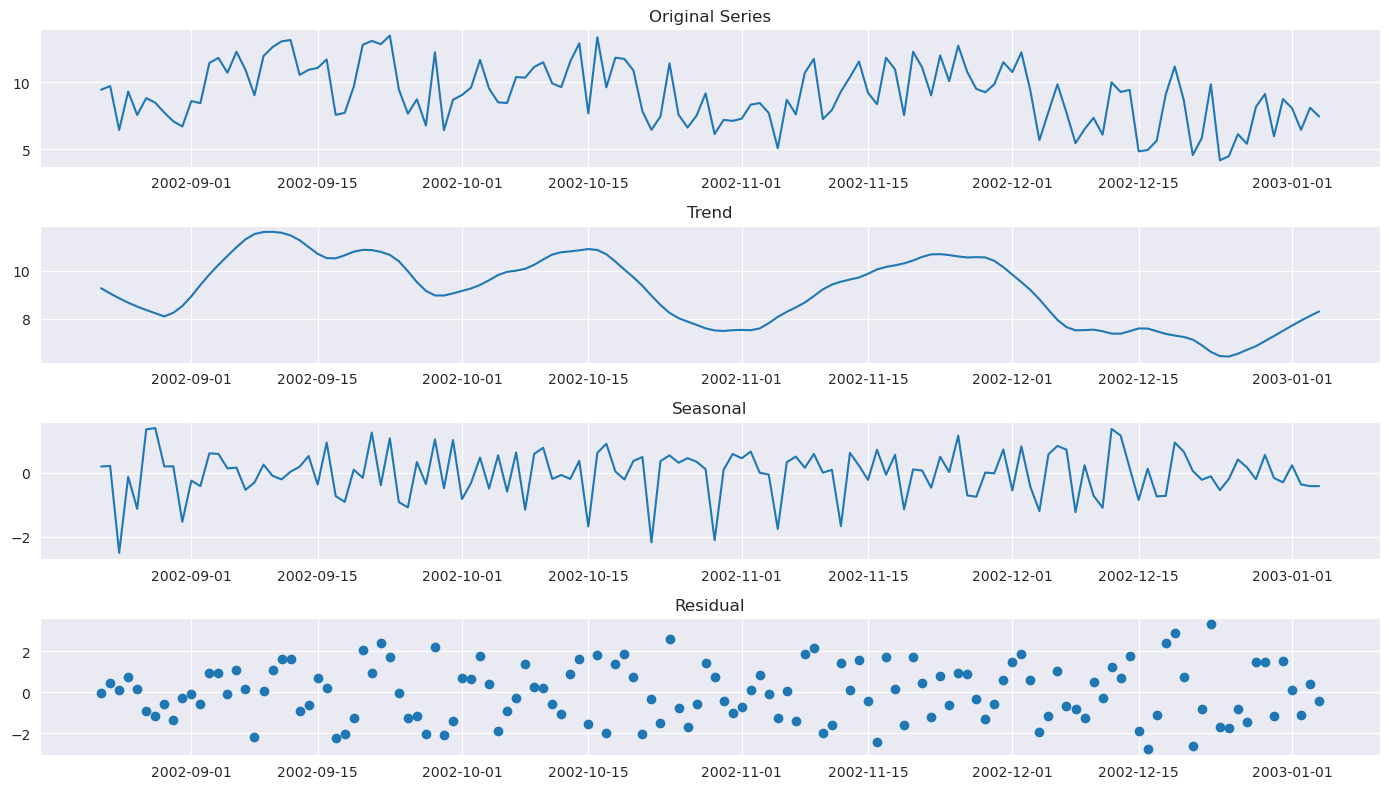

Epoch 93: reducing lr to 4.908235771726744e-05
No improvement since epoch 90: early stopping
Métricas de Treinamento para <class 'tsai.models.RNNPlus.LSTMPlus'>


train_loss    0.675763
valid_loss    0.628074
mae           1.020881
_rmse         1.293337
dtype: float64

Performing stepwise search to minimize bic
 ARIMA(4,1,0)(0,0,0)[0] intercept   : BIC=-530.291, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=-124.351, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=-525.949, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=-335.782, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=-127.881, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=-533.678, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=-538.934, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=-533.599, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=-537.425, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=-528.142, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=-544.184, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=-531.256, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : BIC=-538.935, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : BIC=-538.852, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]          

[I 2024-12-18 22:42:28,998] A new study created in memory with name: no-name-81705503-e47c-4080-a94d-3e2772cb7bd4
[I 2024-12-18 22:42:29,143] Trial 0 finished with value: 17.222161625616195 and parameters: {'initialization_method': 'heuristic', 'smoothing_level': 0.9823253105178212, 'smoothing_slope': 0.21741654792548512, 'smoothing_seasonal': 0.5418785626699829, 'seasonal_periods': 20}. Best is trial 0 with value: 17.222161625616195.
[I 2024-12-18 22:42:29,357] Trial 1 finished with value: 9.090759776659342 and parameters: {'initialization_method': 'estimated', 'smoothing_level': 0.6698412586445697, 'smoothing_slope': 0.33587978152984455, 'smoothing_seasonal': 0.24842101494239704, 'seasonal_periods': 8}. Best is trial 1 with value: 9.090759776659342.


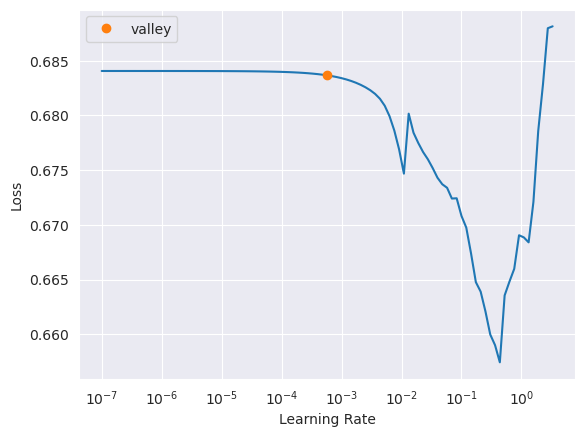

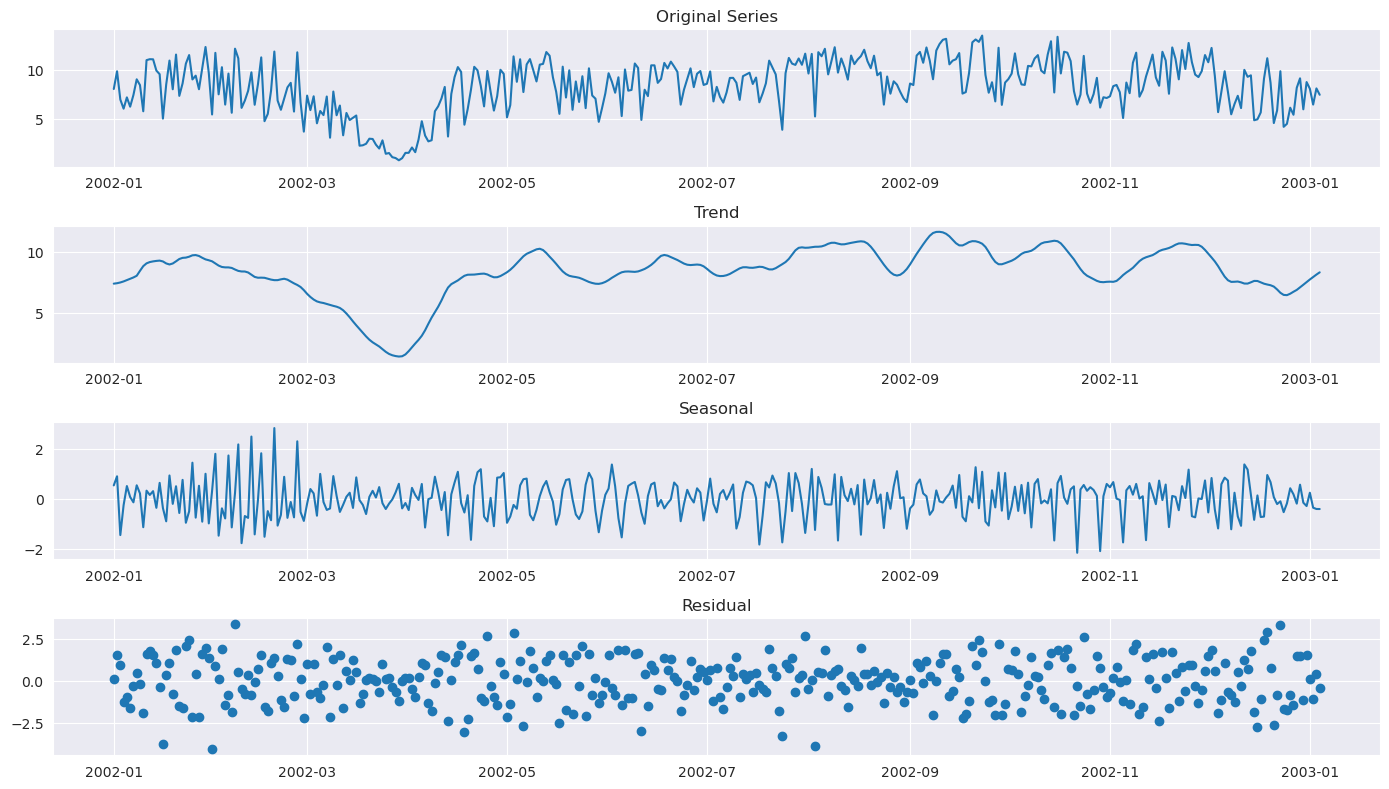

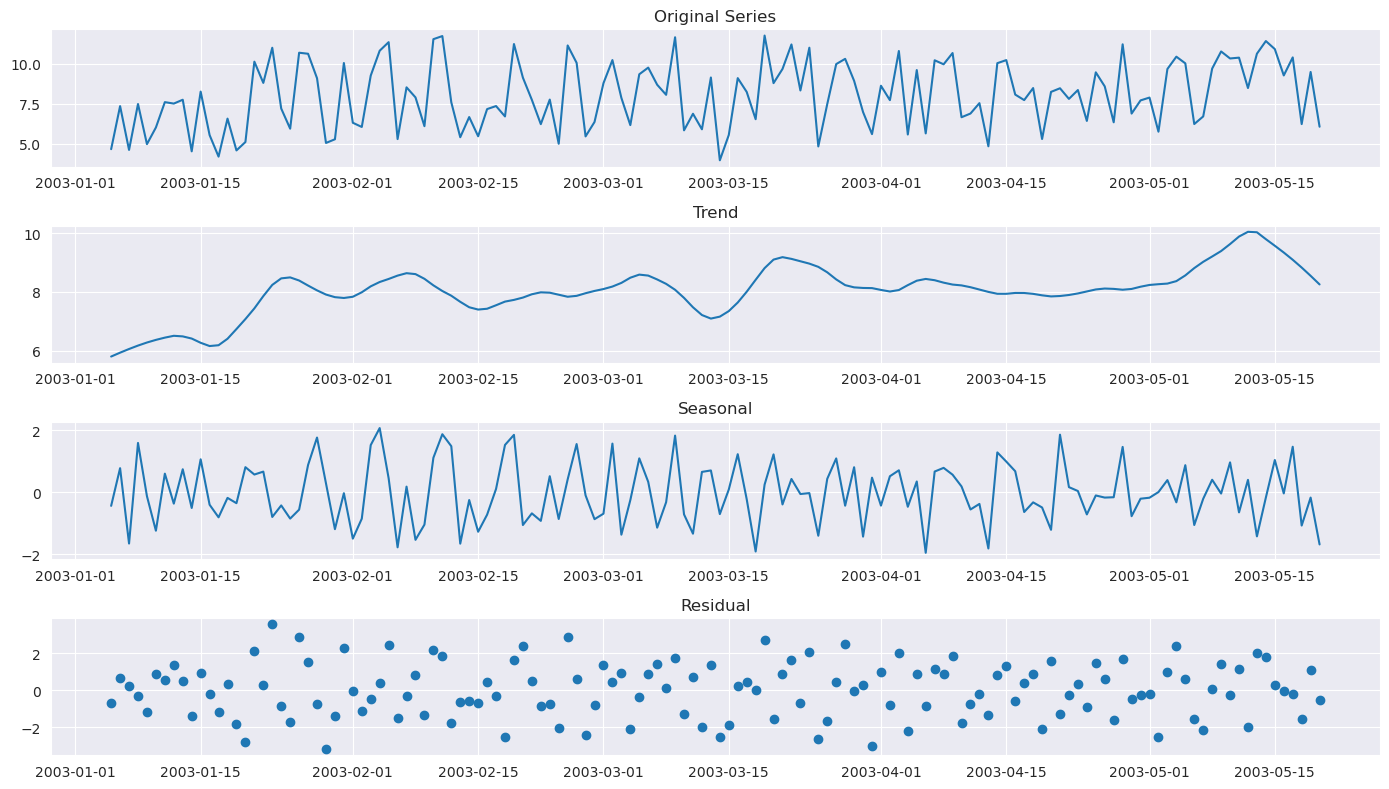

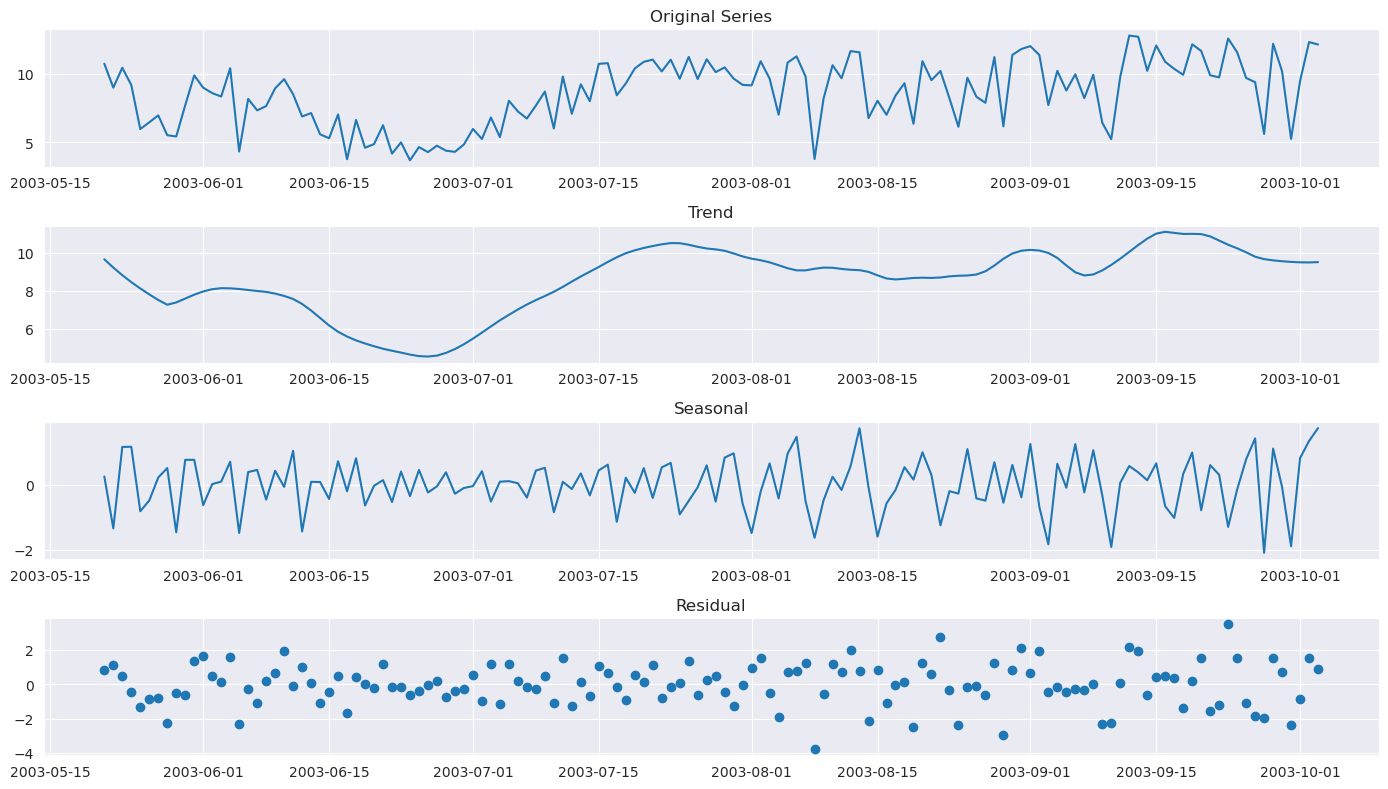

Epoch 106: reducing lr to 3.1335120594121797e-05
No improvement since epoch 103: early stopping
Métricas de Treinamento para <class 'tsai.models.RNNPlus.LSTMPlus'>


train_loss    0.683225
valid_loss    0.776946
mae           1.194344
_rmse         1.448840
dtype: float64

Performing stepwise search to minimize bic
 ARIMA(4,1,0)(0,0,0)[0] intercept   : BIC=-359.710, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=-91.760, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=-360.642, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=-250.284, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=-97.951, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=-371.804, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=-365.590, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=-365.587, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=-370.318, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=-359.388, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=-378.027, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=-366.863, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : BIC=-371.812, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : BIC=-371.810, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]            

[I 2024-12-18 22:42:40,551] A new study created in memory with name: no-name-98819275-e7f5-4b4c-94a1-da9cd6f58970
[I 2024-12-18 22:42:40,931] Trial 0 finished with value: 11.434210356706487 and parameters: {'initialization_method': 'estimated', 'smoothing_level': 0.79625731769168, 'smoothing_slope': 0.18675544430616167, 'smoothing_seasonal': 0.14389091715450292, 'seasonal_periods': 16}. Best is trial 0 with value: 11.434210356706487.
[I 2024-12-18 22:42:41,217] Trial 1 finished with value: 10.76428281334428 and parameters: {'initialization_method': 'estimated', 'smoothing_level': 0.5239644555576607, 'smoothing_slope': 0.26159764658624457, 'smoothing_seasonal': 0.44305201672298256, 'seasonal_periods': 8}. Best is trial 1 with value: 10.76428281334428.


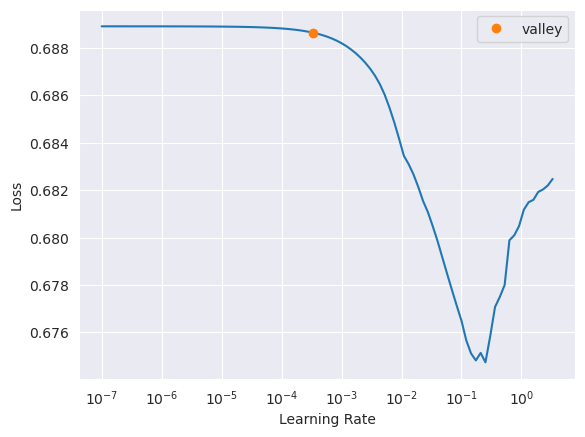

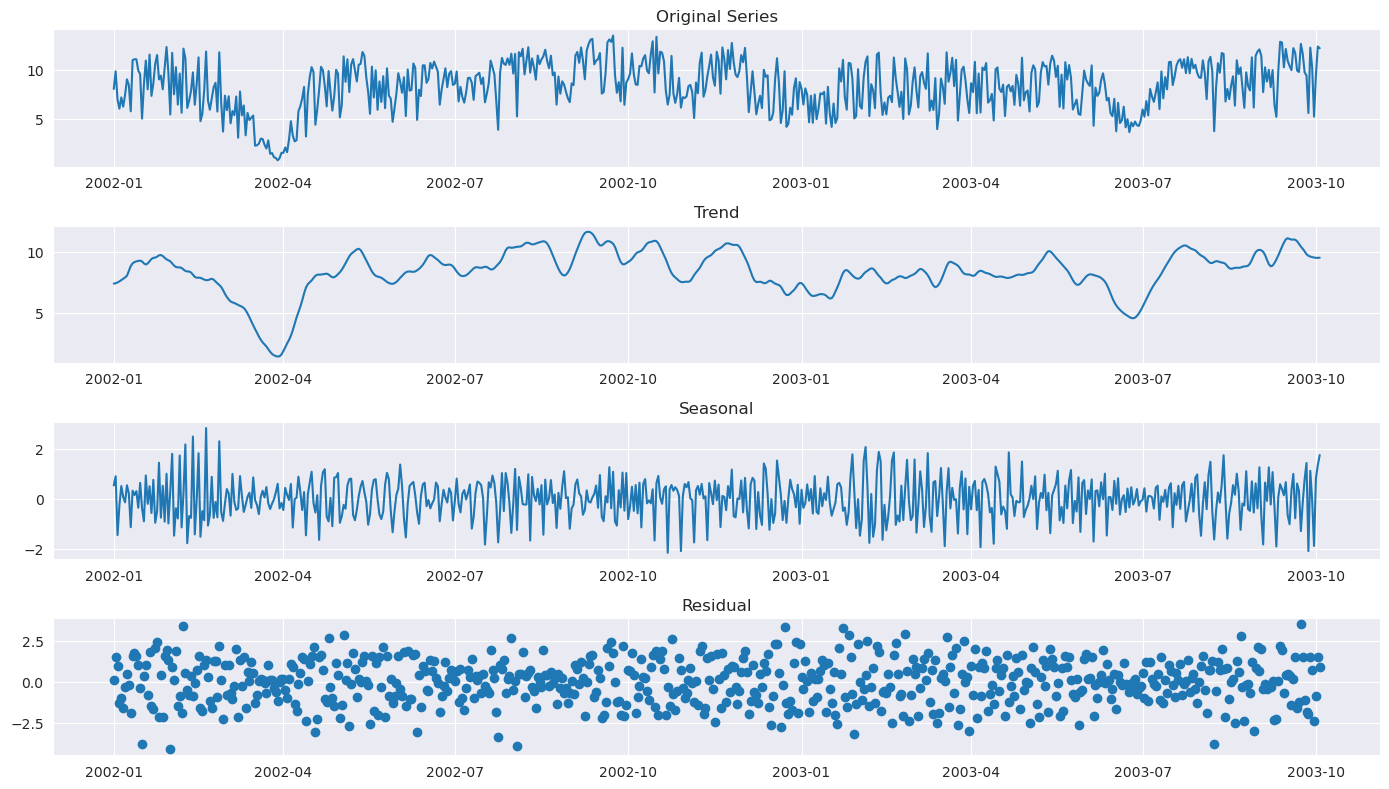

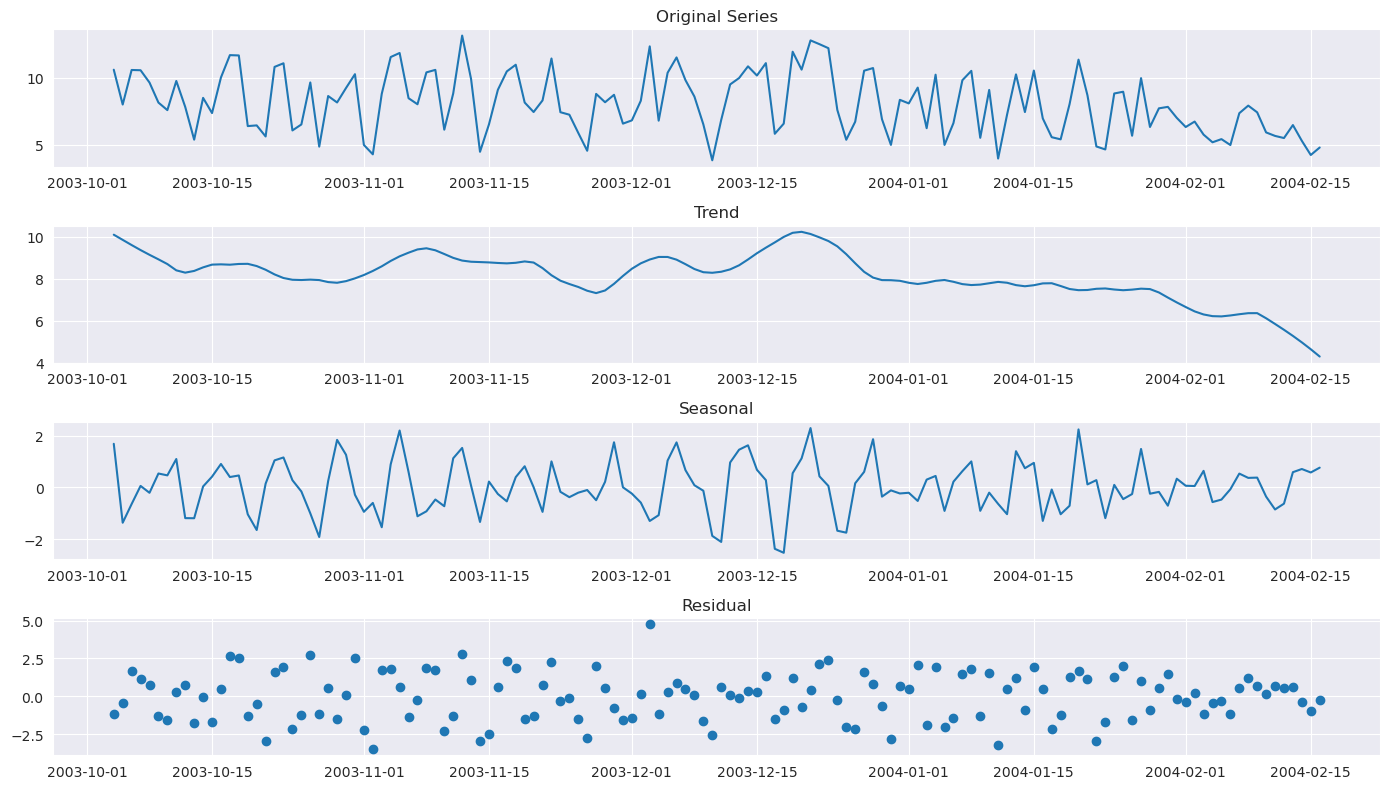

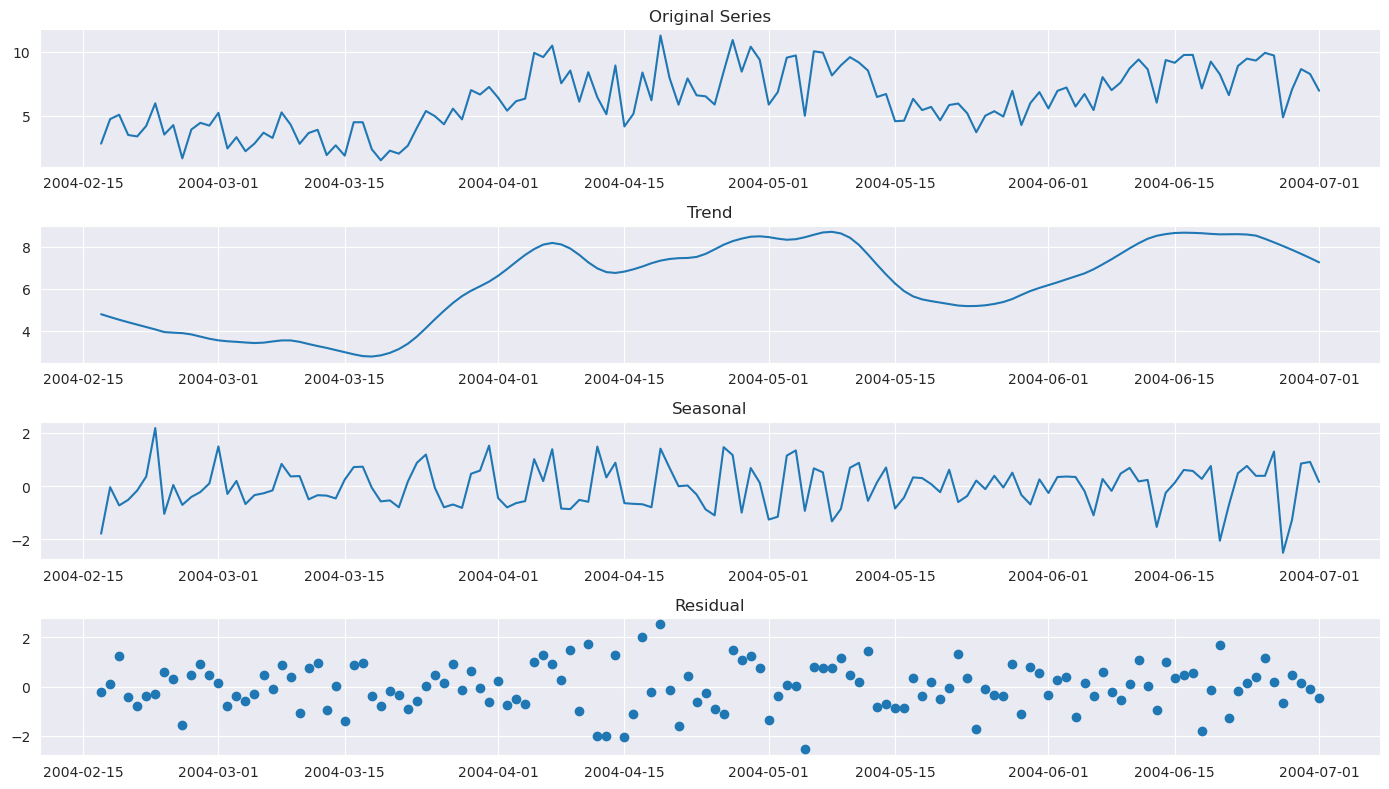

Epoch 27: reducing lr to 0.00048457097393498976
No improvement since epoch 24: early stopping
Métricas de Treinamento para <class 'tsai.models.RNNPlus.LSTMPlus'>


train_loss    0.666651
valid_loss    0.853279
mae           1.283246
_rmse         1.551783
dtype: float64

Performing stepwise search to minimize bic
 ARIMA(4,0,0)(0,0,0)[0]             : BIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=5529.981, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-1148.655, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-1874.109, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : BIC=-1912.260, Time=0.57 sec
 ARIMA(3,0,0)(0,0,0)[0]             : BIC=inf, Time=0.05 sec
 ARIMA(4,0,1)(0,0,0)[0]             : BIC=-1906.090, Time=0.54 sec
 ARIMA(3,0,2)(0,0,0)[0]             : BIC=-1916.398, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=-1918.675, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-1585.834, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : BIC=-1921.719, Time=0.43 sec
 ARIMA(1,0,3)(0,0,0)[0]             : BIC=-1797.72

[I 2024-12-18 22:43:06,584] A new study created in memory with name: no-name-18decd4a-7052-41dc-804c-2efd53021104
[I 2024-12-18 22:43:08,772] Trial 0 finished with value: 16.834803479798882 and parameters: {'initialization_method': 'estimated', 'smoothing_level': 0.2932704347631173, 'smoothing_slope': 0.6016962506288782, 'smoothing_seasonal': 0.6719881312645761, 'seasonal_periods': 25}. Best is trial 0 with value: 16.834803479798882.
[I 2024-12-18 22:43:09,536] Trial 1 finished with value: 104.97558439637211 and parameters: {'initialization_method': 'estimated', 'smoothing_level': 0.7874580317698499, 'smoothing_slope': 0.7856000022017281, 'smoothing_seasonal': 0.28193327543711044, 'seasonal_periods': 26}. Best is trial 0 with value: 16.834803479798882.


Default LSTM


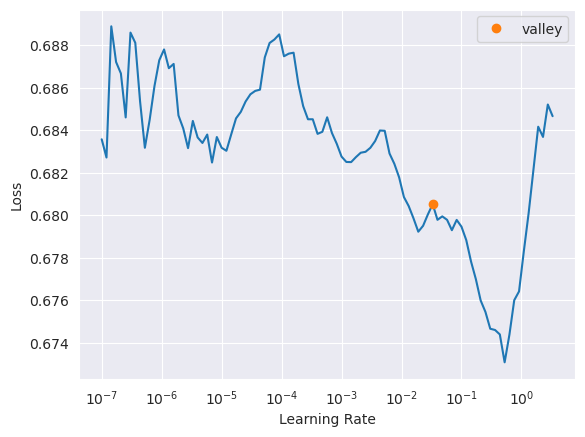

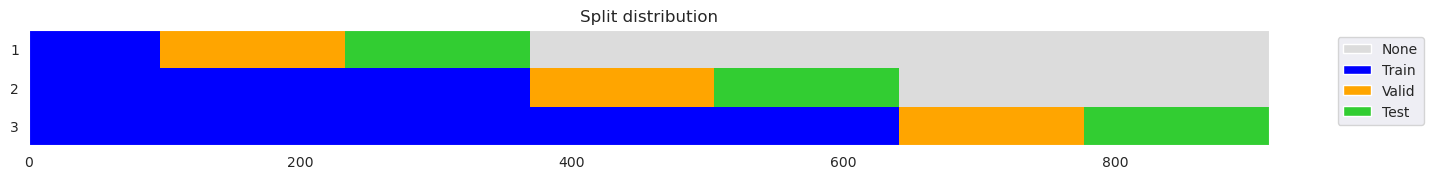

Epoch 99: reducing lr to 0.00013025080098365028
No improvement since epoch 96: early stopping
Métricas de Treinamento para <class 'tsai.models.RNNPlus.LSTMPlus'>


train_loss    4.525128
valid_loss    3.688106
mae           4.167198
_rmse         5.086945
dtype: float64

Métricas de Treinamento para <class 'tsai.models.RNNPlus.LSTMPlus'>


train_loss    2.628200
valid_loss    2.328903
mae           2.790307
_rmse         3.659625
dtype: float64

Epoch 54: reducing lr to 0.00026388946079021643
No improvement since epoch 51: early stopping
Métricas de Treinamento para <class 'tsai.models.RNNPlus.LSTMPlus'>


train_loss    6.137436
valid_loss    3.554860
mae           4.025954
_rmse         5.000494
dtype: float64

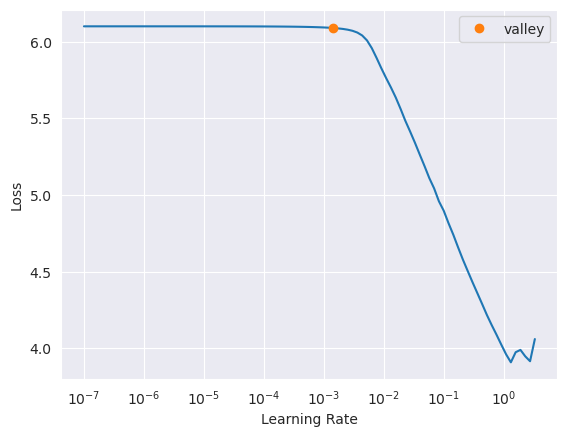

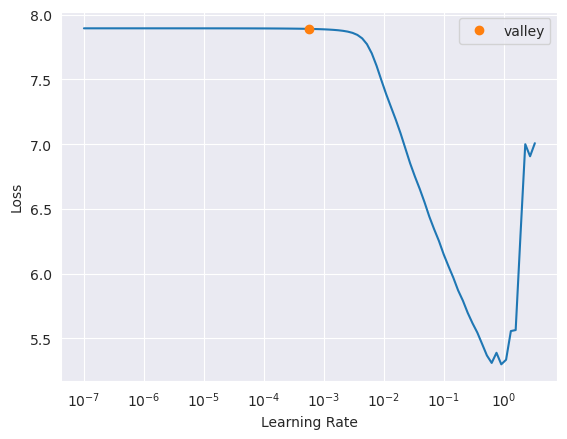

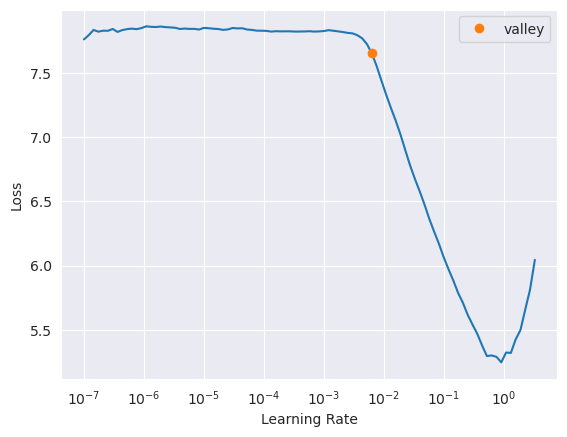

In [187]:
if __name__ == '__main__':
    resultados_dos_modelos = []
    hybrid_forecast, lstm_forecast, target_hybrid, target_lstm, index_date, df_metrics = main()
    resultados_dos_modelos.append(df_metrics)

In [188]:
df_metrics

,rmse,mae,r2,mape,corr
STL-ARIMA-ES-LSTM,2.981076,2.453393,-0.312922,0.387648,0.307960
LSTM,4.691046,3.765515,-2.135935,0.547105,-0.031145
